# Лабораторная работа №4. Шум
## Сергиенко Кирилл, 5130901/10202

## Упраженение 4.1

In [1]:
import os
import wget

if not os.path.exists('../thinkplot.py'):
    wget.download('https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkplot.py')

In [2]:
import numpy as np
import sys
import pandas as pd
sys.path.append('../')
from thinkdsp import read_wave, decorate, Wave, Spectrum, Noise
from thinkplot import config

Скачаем с сайта Soft Murmur звук моря. Послушаем его и распечатаем спектр:

In [3]:
sea = read_wave('sea.wav')
sea = sea.segment(start=2, duration=1)
sea.make_audio()

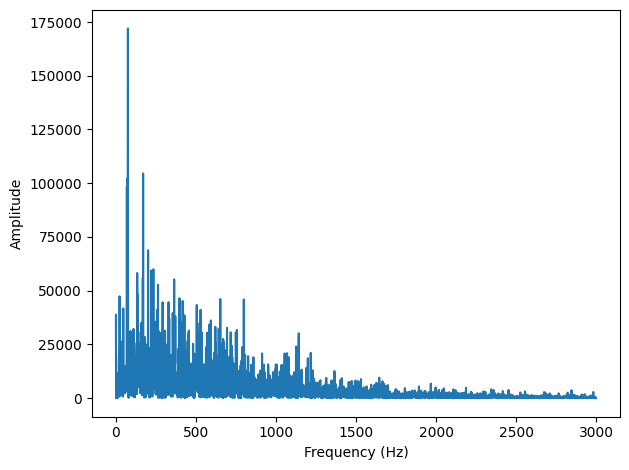

In [4]:

sea_spec = sea.make_spectrum()
sea_spec.plot_power(high=3000)
decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude')

In [5]:
sea_spec.estimate_slope()[0]

-2.1016396879515744

Из полученного графика видно, что зависимость падения амплитуды от частоты отдаленно напоминает красный шум. Наклон спектра также ближе всего к красному шуму. Взглянем на спектр мощности в логарифмическом масштабе.

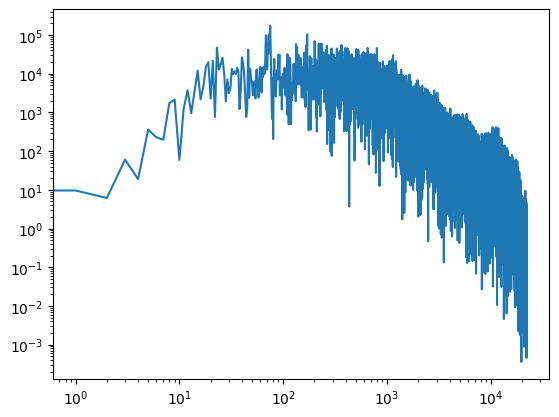

In [6]:
sea_spec.plot_power()
config(xscale='log', yscale='log')

## Упражнение 4.2
Реализуем метод Бартлетта:

In [8]:
def bartlett_method(wave, seg_length=512, win_flag=True):
    sp = wave.make_spectrogram(seg_length, win_flag) 
    specs = sp.spec_map.values()

    psds = [spectrum.power for spectrum in specs] 
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(specs)).fs

    return Spectrum(hs, fs, wave.framerate)


Используем метод для оценки мощности шумового сигнала из первого упаржнения.

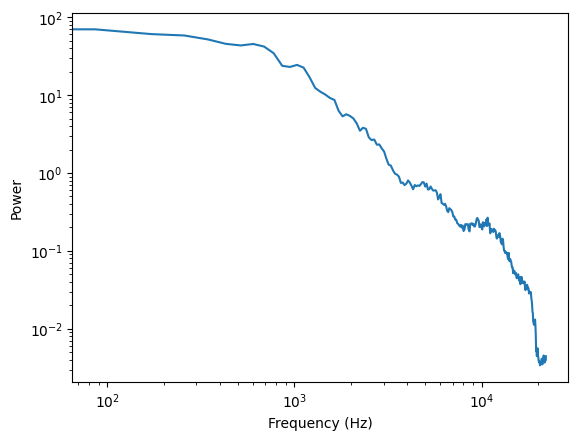

In [9]:
psd = bartlett_method(sea) 
psd.plot_power() 
config(xlabel='Frequency (Hz)', ylabel='Power', xscale='log', yscale='log')

Метод Барлета используется для того, чтобы разорвать сигнал на сегменты, вычис-
лить спектр мощности для каждого сегмента и затем найти среднее.

## Упражнение 4.3
Скачаем файл с историческими данными о цене биткоина и вычислим сектр цен как фукнцию времени.

C:\Users\kiril\AppData\Local\Temp\ipykernel_18020\1018347010.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('BTC-Daily.csv', parse_dates=[0])


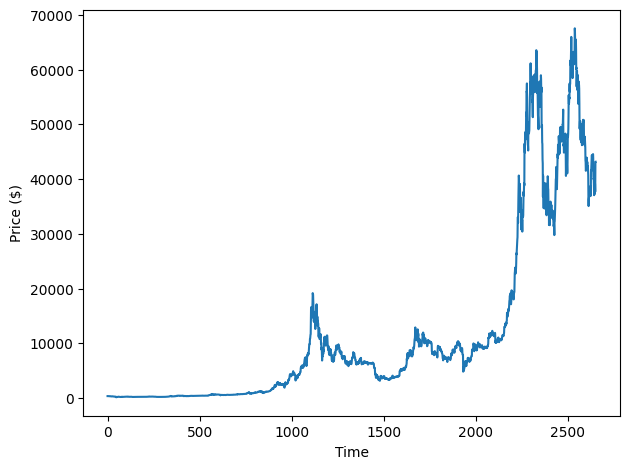

In [11]:
df = pd.read_csv('BTC-Daily.csv', parse_dates=[0])

ys = df['close']
ys = np.flip(ys)
ts = df.index
wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time', ylabel='Price ($)')

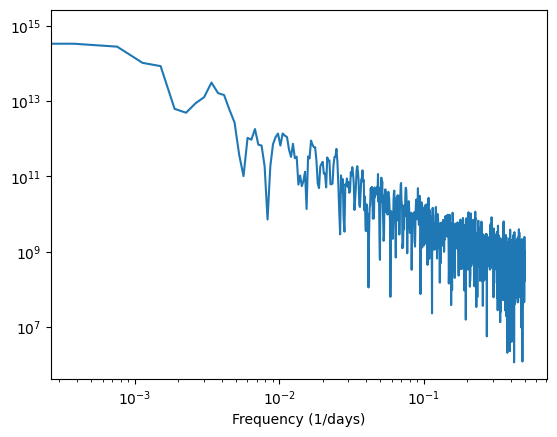

In [12]:
spectrum = wave.make_spectrum() 
spectrum.plot_power() 
config(xlabel='Frequency (1/days)', xscale='log', yscale='log')

In [14]:
spectrum.estimate_slope()[0]

-1.7554871551484157

Наклон спектра приблизительно равен 1.8, что ближе всего к красному шуму, наклон спектра которого равен 2.

## Упражнение 4.4
Напишем класс UncorrelatedPoissonNoise, который наследуется от класса thinkdsp._Noise, который моделирует некоррелированный пуассоновский шум (UP).

In [15]:
class UncorrelatedPoissonNoise(Noise):
    """Represents Uncorrelated Poisson noise."""

    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        Computes Uncorrelated Poisson noise by taking the cumulative sum of
        a uniform random series.

        ts: float array of times

        returns: float wave array
        """
        ys = np.random.poisson(self.amp, len(ts)) 
        return ys

Сгенерируем пару секунд сигнала для малого значения амплитуды. Послушаем.

In [16]:
signal = UncorrelatedPoissonNoise(amp=0.001)
wave = signal.make_wave(duration=2, framerate=10000) 
wave.make_audio()


Слышен треск, как у счётчика Гейгера. 

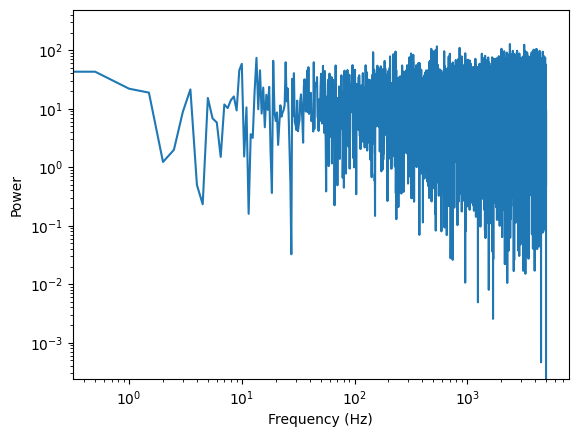

In [17]:
spectrum = wave.make_spectrum() 
spectrum.plot_power()
config(xlabel='Frequency (Hz)', ylabel='Power', xscale='log', yscale='log')

Сгенерируем сигнал с большей амплитудой.

In [18]:
signal = UncorrelatedPoissonNoise(amp=1)
wave = signal.make_wave(duration=2, framerate=10000) 
wave.make_audio()


Слышен белый шум.

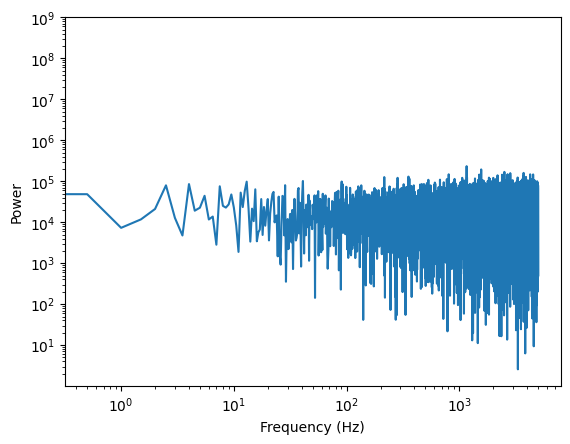

In [19]:
spectrum = wave.make_spectrum() 
spectrum.plot_power()
config(xlabel='Frequency (Hz)', ylabel='Power', xscale='log', yscale='log')

## Упражнение 4.5
Алгоритм Vass-McCartney эффективен для генерации розового шума. Реализуем его.

In [21]:
def voss(nrows, ncols=16):
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.ffill(axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

Сгенерируем сигнал, вычислим его спектр.

In [22]:
signal = voss(1000)
ts = np.arange(len(signal))
wave = Wave(signal, ts, framerate=1000)
wave.make_audio()

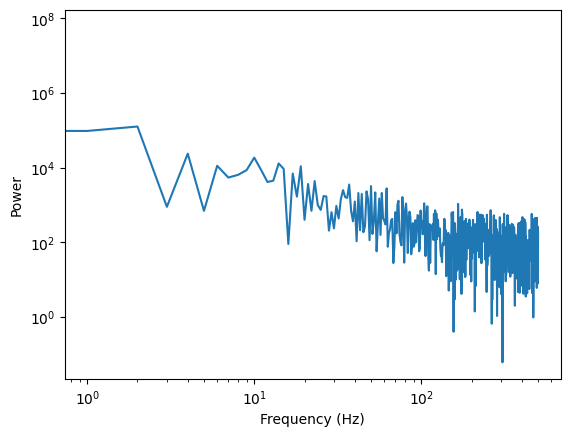

In [23]:
spectrum = wave.make_spectrum() 
spectrum.plot_power()
config(xlabel='Frequency (Hz)', ylabel='Power', xscale='log', yscale='log')

In [24]:
spectrum.estimate_slope()[0]

-1.0722903420367726

Соотношение между мощностью и частотой соответствует розовому шуму. Наклон спектра, приблизительно равный 1, это подтверждает.